## Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc
import pickle
import optuna
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import QuantileTransformer

import re
import nltk
import string
from textblob import TextBlob
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import BayesianRidge, Lasso, ElasticNet

## Load source datasets

In [2]:
train_df = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
train_df.drop(['url_legal','license','standard_error'], inplace=True, axis=1)
train_df.set_index("id", inplace=True)
print(f"train_df: {train_df.shape}\n")
train_df.head()

train_df: (2834, 2)



,excerpt,target
id,,
c12129c31,When the young people returned to the ballroom...,-0.340259
85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",-0.315372
b69ac6792,"As Roger had predicted, the snow departed as q...",-0.580118
dd1000b26,And outside before the palace a great garden w...,-1.054013
37c1b32fb,Once upon a time there were Three Bears who li...,0.247197


In [3]:
test_df = pd.read_csv("../input/commonlitreadabilityprize/test.csv")
test_df.drop(['url_legal','license'], inplace=True, axis=1)
test_df.set_index("id", inplace=True)
print(f"test_df: {test_df.shape}\n")
test_df.head()

test_df: (7, 1)



,excerpt
id,
c0f722661,My hope lay in Jack's promise that he would ke...
f0953f0a5,Dotty continued to go to Mrs. Gray's every nig...
0df072751,It was a bright and cheerful scene that greete...
04caf4e0c,Cell division is the process by which a parent...
0e63f8bea,Debugging is the process of finding and resolv...


## Extract target label

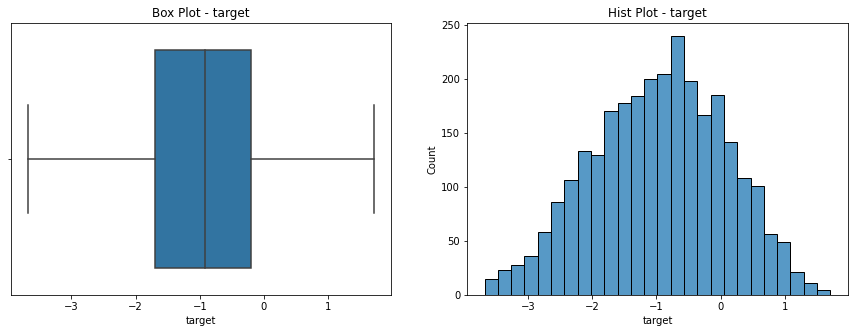

In [4]:
_, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x='target', data=train_df, ax=ax[0])
sns.histplot(x='target', data=train_df, ax=ax[1])
ax[0].title.set_text('Box Plot - target')
ax[1].title.set_text('Hist Plot - target')

In [5]:
Ytrain = train_df['target'].values
Ytrain_strat = pd.qcut(train_df['target'].values, q=5, labels=range(0,5))
train_df.drop(['target'], inplace=True, axis=1)
print("Ytrain: {}".format(Ytrain.shape))

Ytrain: (2834,)


## Feature Engineering

In [6]:
def decontraction(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [7]:
def dialog_parser(text):
    
    tokenized = nltk.word_tokenize(text)
    
    # let's set up some lists to hold our pieces of narrative and dialog
    parsed_dialog = []
    parsed_narrative = []
    
    # and this list will be a bucket for the text we're currently exploring
    current = []

    # now let's set up values that will help us loop through the text
    length = len(tokenized)
    found_q = False
    counter = 0
    quote_open, quote_close = '``', "''"

    # now we'll start our loop saying that as long as our sentence is...
    while counter < length:
        word = tokenized[counter]

        # until we find a quotation mark, we're working with narrative
        if quote_open not in word and quote_close not in word:
            current.append(word)

        # here's what we do when we find a closed quote
        else:
            # we append the narrative we've collected & clear our our
            # current variable
            parsed_narrative.append(current)
            current = []
            
            # now current is ready to hold dialog and we're working on
            # a piece of dialog
            current.append(word)
            found_q = True

            # while we're in the quote, we're going to increment the counter
            # and append to current in this while loop
            while found_q and counter < length-1:
                counter += 1
                if quote_close not in tokenized[counter]:
                    current.append(tokenized[counter])
                else:
                    # if we find a closing quote, we add our dialog to the
                    # appropriate list, clear current and flip our found_q
                    # variable to False
                    current.append(tokenized[counter])
                    parsed_dialog.append(current)
                    current = []
                    found_q = False

        # increment the counter to move us through the text
        counter += 1
    
    if len(parsed_narrative) == 0:
        parsed_narrative.append(current)
    
    mean_dialog_word_len = 0
    
    if len(parsed_dialog) > 0:
        for text in parsed_dialog:
            join_text = " ".join(text)
            join_text = join_text.replace('"','')
            join_text = join_text.replace("''","")
            mean_dialog_word_len += len(join_text.split())
        
        mean_dialog_word_len /= float(len(parsed_dialog))
    
    mean_narrative_word_len = 0
    
    if len(parsed_narrative) > 0:
        for text in parsed_narrative:
            join_text = " ".join(text)
            join_text = join_text.replace('"','')
            join_text = join_text.replace("''","")
            mean_narrative_word_len += len(join_text.split())
        
        mean_narrative_word_len /= float(len(parsed_narrative))

    return len(parsed_dialog), len(parsed_narrative), mean_dialog_word_len, mean_narrative_word_len

In [8]:
def remove_punctuations(text):
    punct = []
    punct += list(string.punctuation)
    punct += '’'
    punct += '-'
    punct += ','
    punct += '.'
    punct += '?'
    punct += '!'
    punct.remove('"')
    
    for punctuation in punct:
        text = text.replace(punctuation, '')
    return text

In [9]:
def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {
        "N": wordnet.NOUN, 
        "V": wordnet.VERB, 
        "J": wordnet.ADJ, 
        "R": wordnet.ADV
    }
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [10]:
combined_df = train_df.append(test_df, sort=False, ignore_index=False)

del train_df
del test_df
gc.collect()

combined_df.head()

,excerpt
id,
c12129c31,When the young people returned to the ballroom...
85aa80a4c,"All through dinner time, Mrs. Fayre was somewh..."
b69ac6792,"As Roger had predicted, the snow departed as q..."
dd1000b26,And outside before the palace a great garden w...
37c1b32fb,Once upon a time there were Three Bears who li...


In [11]:
punct = []
punct += list(string.punctuation)
punct += '’'
punct += '-'
punct += ','
punct += '.'
punct += '?'
punct += '!'


combined_df["excerpt_num_words"] = combined_df["excerpt"].apply(lambda x: len(str(x).split()))
combined_df["excerpt_num_unique_words"] = combined_df["excerpt"].apply(lambda x: len(set(str(x).split())))
combined_df["excerpt_num_chars"] = combined_df["excerpt"].apply(lambda x: len(str(x)))
combined_df["excerpt_num_stopwords"] = combined_df["excerpt"].apply(lambda x: len([w for w in str(x).lower().split() if w in set(stopwords.words('english'))]))
combined_df["excerpt_num_punctuations"] =combined_df['excerpt'].apply(lambda x: len([c for c in str(x) if c in punct]))
combined_df["excerpt_num_words_upper"] = combined_df["excerpt"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
combined_df["excerpt_num_words_title"] = combined_df["excerpt"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
combined_df["excerpt_mean_word_len"] = combined_df["excerpt"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
combined_df.head()

,excerpt,excerpt_num_words,excerpt_num_unique_words,excerpt_num_chars,excerpt_num_stopwords,excerpt_num_punctuations,excerpt_num_words_upper,excerpt_num_words_title,excerpt_mean_word_len
id,,,,,,,,,
c12129c31,When the young people returned to the ballroom...,179,114,992,88,27,0,16,4.547486
85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",169,127,937,73,56,6,28,4.550296
b69ac6792,"As Roger had predicted, the snow departed as q...",166,128,908,75,47,2,29,4.475904
dd1000b26,And outside before the palace a great garden w...,164,118,909,70,33,0,8,4.548780
37c1b32fb,Once upon a time there were Three Bears who li...,147,51,723,75,32,0,42,3.925170


In [12]:
# Convert to lower case
combined_df['Processed_excerpt'] = combined_df['excerpt'].apply(lambda x: str(x).lower().replace('\\', '').replace('_', ' '))

# Remove double spaces
combined_df['Processed_excerpt'] = combined_df['Processed_excerpt'].apply(lambda x: re.sub('\s+',  ' ', x))

# Replace contractions ("don't" with "do not" and "we've" with "we have")
combined_df['Processed_excerpt'] = combined_df['Processed_excerpt'].apply(lambda x: decontraction(x))

# Remove punctuations
combined_df['Processed_excerpt'] = combined_df['Processed_excerpt'].apply(remove_punctuations)

# Lemmatize words
combined_df['Processed_excerpt'] = combined_df['Processed_excerpt'].apply(lambda text: lemmatize_words(text))

combined_df.head()

,excerpt,excerpt_num_words,excerpt_num_unique_words,excerpt_num_chars,excerpt_num_stopwords,excerpt_num_punctuations,excerpt_num_words_upper,excerpt_num_words_title,excerpt_mean_word_len,Processed_excerpt
id,,,,,,,,,,
c12129c31,When the young people returned to the ballroom...,179,114,992,88,27,0,16,4.547486,when the young people return to the ballroom i...
85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",169,127,937,73,56,6,28,4.550296,all through dinner time mr fayre be somewhat s...
b69ac6792,"As Roger had predicted, the snow departed as q...",166,128,908,75,47,2,29,4.475904,a roger have predict the snow depart as quickl...
dd1000b26,And outside before the palace a great garden w...,164,118,909,70,33,0,8,4.548780,and outside before the palace a great garden b...
37c1b32fb,Once upon a time there were Three Bears who li...,147,51,723,75,32,0,42,3.925170,once upon a time there be three bear who live ...


In [13]:
combined_df["excerpt_num_dialog"] = combined_df["Processed_excerpt"].apply(lambda x: dialog_parser(x)[0])
combined_df["excerpt_num_narrative"] = combined_df["Processed_excerpt"].apply(lambda x: dialog_parser(x)[1])
combined_df["excerpt_dialog_mean_word_len"] = combined_df["Processed_excerpt"].apply(lambda x: dialog_parser(x)[2])
combined_df["excerpt_narrative_mean_word_len"] = combined_df["Processed_excerpt"].apply(lambda x: dialog_parser(x)[3])
combined_df['excerpt_polarity'] = combined_df['Processed_excerpt'].apply(lambda x: TextBlob(x).sentiment[0])
combined_df['excerpt_subjectivity'] = combined_df['Processed_excerpt'].apply(lambda x: TextBlob(x).sentiment[1])
combined_df.head()

,excerpt,excerpt_num_words,excerpt_num_unique_words,excerpt_num_chars,excerpt_num_stopwords,excerpt_num_punctuations,excerpt_num_words_upper,excerpt_num_words_title,excerpt_mean_word_len,Processed_excerpt,excerpt_num_dialog,excerpt_num_narrative,excerpt_dialog_mean_word_len,excerpt_narrative_mean_word_len,excerpt_polarity,excerpt_subjectivity
id,,,,,,,,,,,,,,,,
c12129c31,When the young people returned to the ballroom...,179,114,992,88,27,0,16,4.547486,when the young people return to the ballroom i...,0,1,0.0,179.0,0.123611,0.481944
85aa80a4c,"All through dinner time, Mrs. Fayre was somewh...",169,127,937,73,56,6,28,4.550296,all through dinner time mr fayre be somewhat s...,6,6,15.0,12.0,0.144808,0.579608
b69ac6792,"As Roger had predicted, the snow departed as q...",166,128,908,75,47,2,29,4.475904,a roger have predict the snow depart as quickl...,5,5,19.2,15.8,0.061064,0.594678
dd1000b26,And outside before the palace a great garden w...,164,118,909,70,33,0,8,4.548780,and outside before the palace a great garden b...,0,1,0.0,164.0,0.315410,0.604630
37c1b32fb,Once upon a time there were Three Bears who li...,147,51,723,75,32,0,42,3.925170,once upon a time there be three bear who live ...,0,1,0.0,147.0,0.196388,0.565179


<AxesSubplot:>

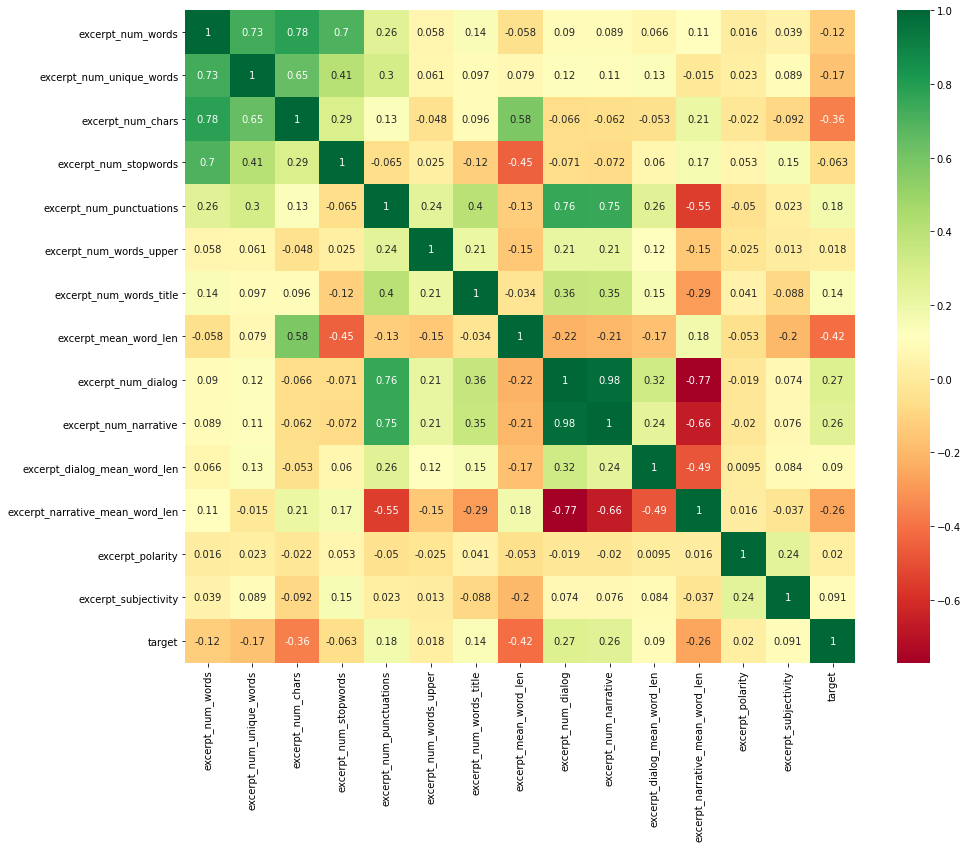

In [14]:
df = combined_df[:Ytrain.shape[0]].copy()
df['target'] = Ytrain
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), annot=True, cmap="RdYlGn")

In [15]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,5), 
                        analyzer='word', max_df=0.95, min_df=3, 
                        use_idf=1, sublinear_tf=1, 
                        max_features=500, strip_accents='ascii')

features = tfidf.fit_transform(combined_df.Processed_excerpt).toarray()

features_df = pd.DataFrame(features, 
                           columns=tfidf.get_feature_names(), 
                           index=combined_df.index)

combined_df = pd.merge(combined_df, 
                       features_df, 
                       left_index=True, 
                       right_index=True)

combined_df.shape

(2841, 516)

In [16]:
for i in range(3):
    print(f"\nOriginal Excerpt: \n{combined_df.iloc[i]['excerpt']} \n\nProcessed Excerpt: \n{combined_df.iloc[i]['Processed_excerpt']}\n")
    print("="*150)


Original Excerpt: 
When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.
This would have been an easy matter, but each traveller was obliged to wea

## Glove Embeddings

In [17]:
def sent2vec(text):
    words = nltk.word_tokenize(text)
    words = [w for w in words if w.isalpha()]
    
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    
    return v / np.sqrt((v ** 2).sum())

In [18]:
with open("../input/gloveembeddings/Glove_840B_300d_Embeddings.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
embeddings_index = processed_data['embeddings_index']
print('Word vectors found: {}'.format(len(embeddings_index)))

del processed_data
gc.collect()

Word vectors found: 2196017


0

In [19]:
glove_vec = [sent2vec(x) for x in tqdm(combined_df["Processed_excerpt"].values)]
col_list = ['glove_'+str(i) for i in range(300)]
glove_vec_df = pd.DataFrame(np.array(glove_vec), columns=col_list, index=combined_df.index)
print(f"glove_vec_df: {glove_vec_df.shape}\n")
glove_vec_df.head()

100%|██████████| 2841/2841 [00:04<00:00, 588.28it/s]

glove_vec_df: (2841, 300)



,glove_0,glove_1,glove_2,glove_3,glove_4,glove_5,glove_6,glove_7,glove_8,glove_9,...,glove_290,glove_291,glove_292,glove_293,glove_294,glove_295,glove_296,glove_297,glove_298,glove_299
id,,,,,,,,,,,,,,,,,,,,,
c12129c31,0.021693,0.019253,-0.045825,-0.003977,0.029208,-0.026362,-0.010197,-0.005620,-0.016536,0.653977,...,-0.083007,0.014363,0.013540,-0.050059,-0.031156,0.013722,-0.001021,-0.017041,0.005395,0.036486
85aa80a4c,-0.003606,0.036071,-0.062697,-0.000421,0.025328,-0.009989,0.004103,-0.032784,-0.007713,0.673492,...,-0.039143,0.024974,-0.004702,-0.017256,0.032594,-0.008774,0.001196,-0.004475,0.028065,0.013178
b69ac6792,-0.001263,0.044104,-0.049001,-0.006273,0.024179,-0.014929,-0.002027,-0.027604,-0.006893,0.690508,...,-0.044588,0.008905,-0.008269,-0.033206,0.026196,-0.009536,0.001255,-0.021834,0.029333,0.025893
dd1000b26,0.013577,0.015171,-0.028281,-0.015206,0.029549,-0.019149,-0.001532,0.009319,-0.013907,0.647915,...,-0.065940,0.007587,0.006081,-0.038112,-0.034276,0.012794,0.022731,-0.003692,0.018092,0.034201
37c1b32fb,-0.012050,0.004375,-0.056713,0.006956,0.035358,-0.030953,-0.012690,-0.047643,0.009626,0.639187,...,-0.090096,0.008852,0.028137,-0.029184,-0.020954,0.030462,0.010512,-0.029550,-0.024366,0.021408


In [20]:
combined_df = pd.merge(combined_df, glove_vec_df, how="inner", on="id", sort=False)
combined_df.drop(['excerpt','Processed_excerpt'], inplace=True, axis=1)
print(f"combined_df: {combined_df.shape}\n")
combined_df.head()

combined_df: (2841, 814)



,excerpt_num_words,excerpt_num_unique_words,excerpt_num_chars,excerpt_num_stopwords,excerpt_num_punctuations,excerpt_num_words_upper,excerpt_num_words_title,excerpt_mean_word_len,excerpt_num_dialog,excerpt_num_narrative,...,glove_290,glove_291,glove_292,glove_293,glove_294,glove_295,glove_296,glove_297,glove_298,glove_299
id,,,,,,,,,,,,,,,,,,,,,
c12129c31,179,114,992,88,27,0,16,4.547486,0,1,...,-0.083007,0.014363,0.013540,-0.050059,-0.031156,0.013722,-0.001021,-0.017041,0.005395,0.036486
85aa80a4c,169,127,937,73,56,6,28,4.550296,6,6,...,-0.039143,0.024974,-0.004702,-0.017256,0.032594,-0.008774,0.001196,-0.004475,0.028065,0.013178
b69ac6792,166,128,908,75,47,2,29,4.475904,5,5,...,-0.044588,0.008905,-0.008269,-0.033206,0.026196,-0.009536,0.001255,-0.021834,0.029333,0.025893
dd1000b26,164,118,909,70,33,0,8,4.548780,0,1,...,-0.065940,0.007587,0.006081,-0.038112,-0.034276,0.012794,0.022731,-0.003692,0.018092,0.034201
37c1b32fb,147,51,723,75,32,0,42,3.925170,0,1,...,-0.090096,0.008852,0.028137,-0.029184,-0.020954,0.030462,0.010512,-0.029550,-0.024366,0.021408


In [21]:
Xtrain = combined_df[:Ytrain.shape[0]].copy()
Xtest = combined_df[Ytrain.shape[0]:].copy()
print(f"Xtrain: {Xtrain.shape} \nXtest: {Xtest.shape}")

del combined_df
gc.collect()

Xtrain: (2834, 814) 
Xtest: (7, 814)


40

## Quantile Transformation

In [22]:
for col in tqdm(Xtrain.columns):
    transformer = QuantileTransformer(n_quantiles=1000, 
                                      random_state=10, 
                                      output_distribution="normal")
    
    vec_len = len(Xtrain[col].values)
    vec_len_test = len(Xtest[col].values)

    raw_vec = Xtrain[col].values.reshape(vec_len, 1)
    test_vec = Xtest[col].values.reshape(vec_len_test, 1)
    transformer.fit(raw_vec)
    
    Xtrain[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    Xtest[col] = transformer.transform(test_vec).reshape(1, vec_len_test)[0]

print("Xtrain: {} \nYtrain: {} \nXtest: {}".format(Xtrain.shape, Ytrain.shape, Xtest.shape))

100%|██████████| 814/814 [00:09<00:00, 86.07it/s]

Xtrain: (2834, 814) 
Ytrain: (2834,) 
Xtest: (7, 814)


## Base Models

* **BayesianRidge** (Unused)
* **Lasso**
* **ElasticNet**
* **HistGradientBoostingRegressor** (Unused)
* **LightGBM**
* **XGBoost**

In [23]:
FOLD = 5
NUM_SEED = 3
COUNTER = 0

np.random.seed(0)
seeds = np.random.randint(0, 100, size=NUM_SEED)

#oof_score_ridge = 0
oof_score_lasso = 0
oof_score_enet = 0
#oof_score_gbr = 0
oof_score_lgb = 0
oof_score_xgb = 0

#y_pred_final_ridge = np.zeros((Xtest.shape[0], NUM_SEED))
y_pred_final_lasso = np.zeros((Xtest.shape[0], NUM_SEED))
y_pred_final_enet = np.zeros((Xtest.shape[0], NUM_SEED))
#y_pred_final_gbr = np.zeros((Xtest.shape[0], NUM_SEED))
y_pred_final_lgb = np.zeros((Xtest.shape[0], NUM_SEED))
y_pred_final_xgb = np.zeros((Xtest.shape[0], NUM_SEED))

#y_pred_meta_ridge = np.zeros((Ytrain.shape[0], NUM_SEED))
y_pred_meta_lasso = np.zeros((Ytrain.shape[0], NUM_SEED))
y_pred_meta_enet = np.zeros((Ytrain.shape[0], NUM_SEED))
#y_pred_meta_gbr = np.zeros((Ytrain.shape[0], NUM_SEED))
y_pred_meta_lgb = np.zeros((Ytrain.shape[0], NUM_SEED))
y_pred_meta_xgb = np.zeros((Ytrain.shape[0], NUM_SEED))

In [24]:
print("Model Name \t\t\tSeed \t\tFold \t\tOOF Score \t\tAggregate OOF Score")

for sidx, seed in enumerate(seeds):
    #seed_score_ridge = 0
    seed_score_lasso = 0
    seed_score_enet = 0
    #seed_score_gbr = 0
    seed_score_lgb = 0
    seed_score_xgb = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain_strat)):
        COUNTER += 1

        train_x, train_y = Xtrain.iloc[train], Ytrain[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain[val]
        
        
        #====================================================================
        #                           Bayesian Ridge
        #====================================================================
        '''
        ridge_model = BayesianRidge()
        ridge_model.fit(train_x, train_y)
        
        y_pred = ridge_model.predict(val_x)
        y_pred_meta_ridge[val, sidx] = y_pred
        y_pred_final_ridge[:, sidx] += ridge_model.predict(Xtest)
        
        score = np.sqrt(mean_squared_error(val_y, y_pred))
        oof_score_ridge += score
        seed_score_ridge += score
        print(f"\nBayesian Ridge \t\t\t{seed} \t\t{idx+1} \t\t{score}")
        '''
        
        #====================================================================
        #                                 Lasso
        #====================================================================
        
        lasso_model = Lasso(alpha=0.025, max_iter=2000, random_state=0)
        lasso_model.fit(train_x, train_y)
        
        y_pred = lasso_model.predict(val_x)
        y_pred_meta_lasso[val, sidx] = y_pred
        y_pred_final_lasso[:, sidx] += lasso_model.predict(Xtest)
        
        score = np.sqrt(mean_squared_error(val_y, y_pred))
        oof_score_lasso += score
        seed_score_lasso += score
        print(f"Lasso         \t\t\t{seed} \t\t{idx+1} \t\t{score}")
        
        
        #====================================================================
        #                              ElasticNet
        #====================================================================
        
        enet_model = ElasticNet(alpha=0.025, max_iter=2000, random_state=0)
        enet_model.fit(train_x, train_y)
        
        y_pred = enet_model.predict(val_x)
        y_pred_meta_enet[val, sidx] = y_pred
        y_pred_final_enet[:, sidx] += enet_model.predict(Xtest)
        
        score = np.sqrt(mean_squared_error(val_y, y_pred))
        oof_score_enet += score
        seed_score_enet += score
        print(f"ElasticNet \t\t\t{seed} \t\t{idx+1} \t\t{score}")
        
        
        #====================================================================
        #                     HistGradientBoostingRegressor
        #====================================================================
        '''
        gbr_model = HistGradientBoostingRegressor(max_depth=6, max_leaf_nodes=52, random_state=0)
        gbr_model.fit(train_x, train_y)
        
        y_pred = gbr_model.predict(val_x)
        y_pred_meta_gbr[val, sidx] = y_pred
        y_pred_final_gbr[:, sidx] += gbr_model.predict(Xtest)
        
        score = np.sqrt(mean_squared_error(val_y, y_pred))
        oof_score_gbr += score
        seed_score_gbr += score
        print(f"GradientBoostingRegressor \t{seed} \t\t{idx+1} \t\t{score}")
        '''
        
        #====================================================================
        #                                LightGBM
        #====================================================================
        
        params = {}
        params["objective"] = 'regression'
        params["metric"] = 'rmse'
        params["boosting"] = 'gbdt'
        params["learning_rate"] = 0.0204
        params["lambda_l2"] = 0.225
        params["num_leaves"] = 52
        params["max_depth"] = 6
        params["feature_fraction"] = 0.75
        params["bagging_fraction"] = 0.65
        params["bagging_freq"] = 10
        params["min_data_in_leaf"] = 15
        params["verbosity"] = -1
        num_rounds = 5000
        
        lgtrain = lgb.Dataset(train_x, label=train_y.ravel())
        lgvalidation = lgb.Dataset(val_x, label=val_y.ravel())

        lgb_model = lgb.train(params, lgtrain, num_rounds, 
                              valid_sets=[lgtrain, lgvalidation], 
                              early_stopping_rounds=100, verbose_eval=False)

        y_pred = lgb_model.predict(val_x, num_iteration=lgb_model.best_iteration)
        y_pred_meta_lgb[val, sidx] = y_pred
        y_pred_final_lgb[:, sidx] += lgb_model.predict(Xtest, num_iteration=lgb_model.best_iteration)
        
        score = np.sqrt(mean_squared_error(val_y, y_pred))
        oof_score_lgb += score
        seed_score_lgb += score
        print(f"LightGBM       \t\t\t{seed} \t\t{idx+1} \t\t{score}")
        
        
        #====================================================================
        #                                XGBoost
        #====================================================================
        
        xgb_model = XGBRegressor(
            objective='reg:squarederror',
            eval_metric='rmse',
            booster='gbtree',
            sample_type='uniform',
            tree_method='hist',
            grow_policy='lossguide',
            num_round=5000,
            #max_depth=11, 
            max_leaves=55,
            learning_rate=0.074,
            subsample=0.74,
            colsample_bytree=0.675,
            min_child_weight=7,
            reg_lambda=0.152,
            verbosity=0
        )

        xgb_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (val_x, val_y)], 
                      early_stopping_rounds=200, verbose=False)

        y_pred = xgb_model.predict(val_x, iteration_range=(0, xgb_model.best_iteration))
        y_pred_meta_xgb[val, sidx] += y_pred
        y_pred_final_xgb[:, sidx] += xgb_model.predict(Xtest, iteration_range=(0, xgb_model.best_iteration))
        
        score = np.sqrt(mean_squared_error(val_y, y_pred))
        oof_score_xgb += score
        seed_score_xgb += score
        print(f"XGBoost     \t\t\t{seed} \t\t{idx+1} \t\t{score}\n")
        
    print("="*110)
    #print(f"Bayesian Ridge \t\t\t{seed} \t\t\t\t\t\t\t{(seed_score_ridge / FOLD)}")
    print(f"Lasso         \t\t\t{seed} \t\t\t\t\t\t\t{(seed_score_lasso / FOLD)}")
    print(f"ElasticNet \t\t\t{seed} \t\t\t\t\t\t\t{(seed_score_enet / FOLD)}")
    #print(f"GradientBoostingRegressor \t{seed} \t\t\t\t\t\t\t{(seed_score_gbr / FOLD)}")
    print(f"LightGBM       \t\t\t{seed} \t\t\t\t\t\t\t{(seed_score_lgb / FOLD)}")
    print(f"XGBoost     \t\t\t{seed} \t\t\t\t\t\t\t{(seed_score_xgb / FOLD)}")
    print("="*110)

Model Name 			Seed 		Fold 		OOF Score 		Aggregate OOF Score
Lasso         			44 		1 		0.6363314205104637
ElasticNet 			44 		1 		0.6342974619842157
LightGBM       			44 		1 		0.6334457600303551
XGBoost     			44 		1 		0.6595919380128905

Lasso         			44 		2 		0.7101202601782071
ElasticNet 			44 		2 		0.6985342431223157
LightGBM       			44 		2 		0.6751459539126016
XGBoost     			44 		2 		0.692492722319327

Lasso         			44 		3 		0.6809921318646134
ElasticNet 			44 		3 		0.6854303481254268
LightGBM       			44 		3 		0.6576160185983555
XGBoost     			44 		3 		0.6771240320478461

Lasso         			44 		4 		0.649414735573973
ElasticNet 			44 		4 		0.6419050310159541
LightGBM       			44 		4 		0.6453222430983502
XGBoost     			44 		4 		0.6661150455284603

Lasso         			44 		5 		0.6980191730445913
ElasticNet 			44 		5 		0.6864544107442943
LightGBM       			44 		5 		0.6758753621771243
XGBoost     			44 		5 		0.7039458808564009

Lasso         			44 							0.6749755442343697
ElasticNet 

In [25]:
#y_pred_final_ridge = y_pred_final_ridge / float(FOLD)
y_pred_final_lasso = y_pred_final_lasso / float(FOLD)
y_pred_final_enet = y_pred_final_enet / float(FOLD)
#y_pred_final_gbr = y_pred_final_gbr / float(FOLD)
y_pred_final_lgb = y_pred_final_lgb / float(FOLD)
y_pred_final_xgb = y_pred_final_xgb / float(FOLD)

#oof_score_ridge /= float(COUNTER)
oof_score_lasso /= float(COUNTER)
oof_score_enet /= float(COUNTER)
#oof_score_gbr /= float(COUNTER)
oof_score_lgb /= float(COUNTER)
oof_score_xgb /= float(COUNTER)

#print(f"Bayesian Ridge | Aggregate OOF Score: {oof_score_ridge}")
print(f"Lasso | Aggregate OOF Score: {oof_score_lasso}")
print(f"ElasticNet | Aggregate OOF Score: {oof_score_enet}")
#print(f"GradientBoostingRegressor | Aggregate OOF Score: {oof_score_gbr}")
print(f"LightGBM | Aggregate OOF Score: {oof_score_lgb}")
print(f"XGBoost | Aggregate OOF Score: {oof_score_xgb}")

Lasso | Aggregate OOF Score: 0.6751968029944402
ElasticNet | Aggregate OOF Score: 0.6717113851335887
LightGBM | Aggregate OOF Score: 0.657223456829531
XGBoost | Aggregate OOF Score: 0.6794163274990221


## Create submission file

In [26]:
y_pred_final = (y_pred_final_lgb * 0.65) + (y_pred_final_enet * 0.15) + (y_pred_final_xgb * 0.1) + (y_pred_final_lasso * 0.1) 

submit_df = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")
submit_df['target'] = y_pred_final
submit_df.to_csv("./submission.csv", index=False)
submit_df.head()

,id,target
0,c0f722661,-1.057341
1,f0953f0a5,-0.414988
2,0df072751,-0.507938
3,04caf4e0c,-2.195486
4,0e63f8bea,-1.823131
